In [2]:
import pandas as pd

wage = pd.read_csv("../../data/Wage.csv")
wage

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


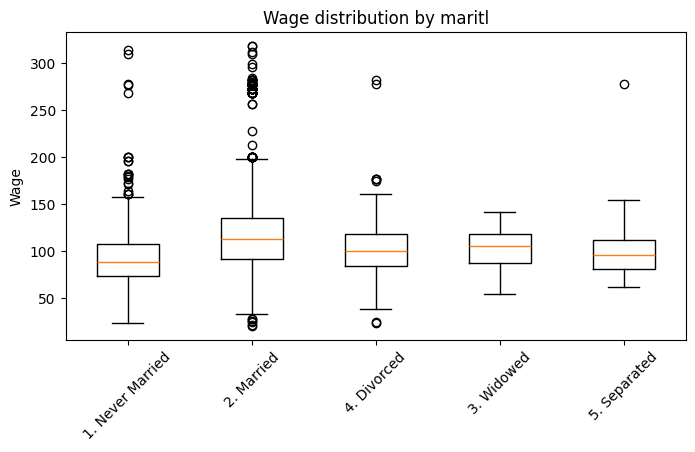

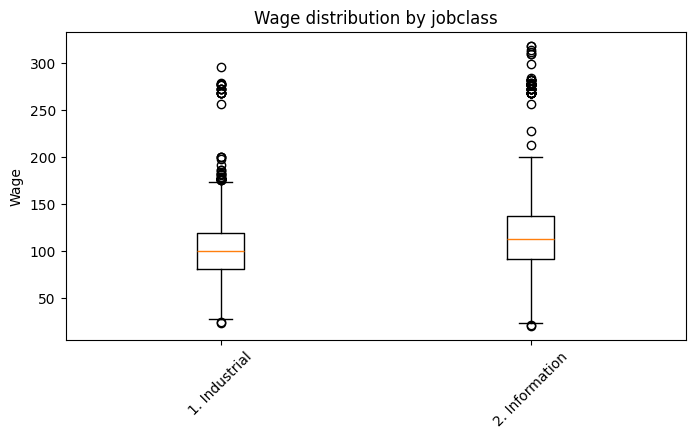

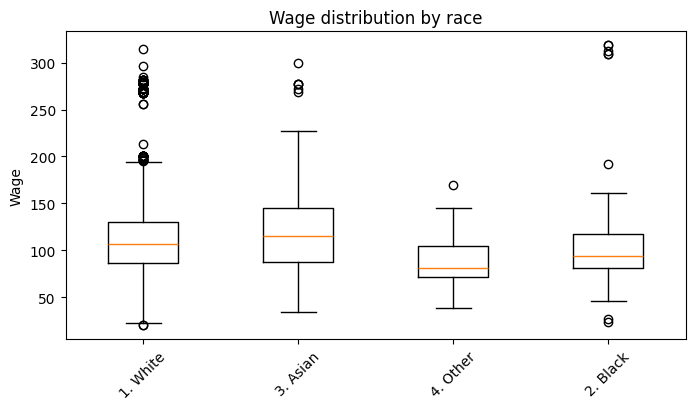

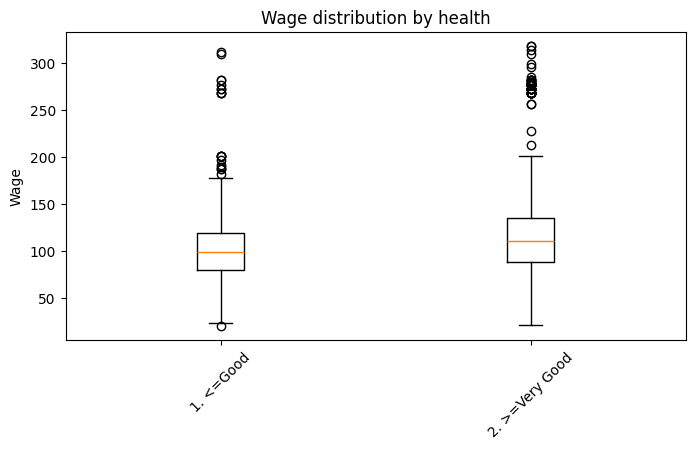

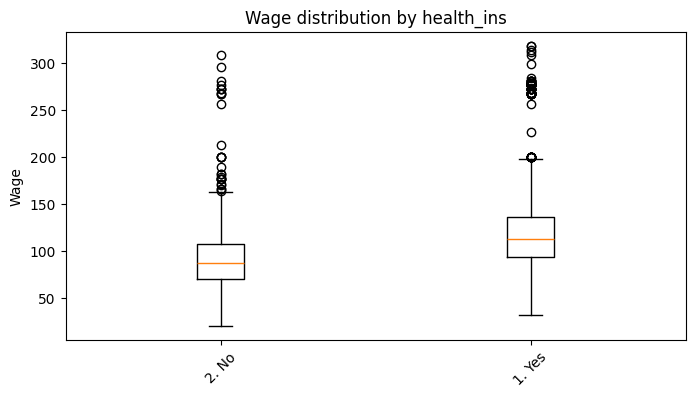

In [3]:
import matplotlib.pyplot as plt

categorical_cols = ['maritl', 'jobclass', 'race', 'health', 'health_ins']

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    categories = wage[col].unique()
    data_to_plot = [wage[wage[col] == category]['wage'] for category in categories]
    
    plt.boxplot(data_to_plot, tick_labels=categories)
    plt.title(f'Wage distribution by {col}')
    plt.xticks(rotation=45)
    plt.ylabel('Wage')
    plt.show()

The boxplots reveal several interesting patterns regarding how categorical variables influence individual wages. For example, married individuals tend to have higher average salaries compared to other marital statuses, with a significant proportion reaching the top wage brackets. This may be explained by their greater financial responsibilities, such as supporting a family or settling down. Never-married individuals also include a notable number of high earners, likely reflecting a career-focused lifestyle and strong professional success.

Similarly, the information industry generally offers higher wages than the industrial sector. However, both sectors include multiple high earners, suggesting that job class alone may not be a strong predictor of an individual’s wage, particularly at the higher end. Health also plays a role: healthier individuals tend to earn more, which aligns with expectations, although some less healthy individuals still reach the top wage brackets. Likewise, having health insurance is associated with higher wages, although this relationship may largely reflect reverse causality, higher earnings make it easier for individuals to obtain health coverage.

In [4]:
import pandas as pd
import numpy as np
from statsmodels.gam.api import GLMGam, BSplines
import matplotlib.pyplot as plt

def effect(x, fixed_vars=None):
    """
    Fit a GAM model for wage with a categorical variable x,
    optionally including additional fixed categorical variables.
    
    Parameters:
        x (str): Main categorical variable to model.
        fixed_vars (dict): Optional dict of additional categorical variables to include.
        
    Returns:
        gam_results: Fitted GLMGamResults object
    """
    wage[x] = wage[x].astype('category')
    
    # Build formula with additional fixed variables
    formula = f"wage ~ C({x})"
    if fixed_vars:
        for var in fixed_vars.keys():
            wage[var] = wage[var].astype('category')
            formula += f" + C({var})"
    
    # Define smoothers for numeric variables
    splines = BSplines(
        wage[["age", "year"]],
        df=[10, 10],
        degree=[3, 3]
    )
    
    # Fit GAM
    gam_model = GLMGam.from_formula(formula, data=wage, smoother=splines)
    gam_results = gam_model.fit()
    
    return gam_results

In [5]:
def plot_effect(x, fixed_vars=None):
    """
    Plot the partial dependence of wage on a categorical variable x,
    optionally fixing other categorical variables to specific values.
    
    Parameters:
        x (str): The main categorical variable to plot.
        fixed_vars (dict): Optional dictionary of {variable: value} to fix.
    """
    wage[x] = wage[x].astype('category')
    
    categories = wage[x].cat.categories

    # Median values for numeric variables
    age_median = wage['age'].median()
    year_median = wage['year'].median()

    # Prepare the prediction DataFrame
    pred_df = pd.DataFrame({
        x: categories,
        'age': [age_median]*len(categories),
        'year': [year_median]*len(categories)
    })

    # Add fixed categorical variables if specified
    if fixed_vars:
        for var, val in fixed_vars.items():
            pred_df[var] = [val]*len(categories)
    
    # Numeric variables for spline smoother
    exog_smooth = np.column_stack([
        pred_df['age'],
        pred_df['year']
    ])

    # Predict
    predictions = effect(x, fixed_vars).predict(exog=pred_df, exog_smooth=exog_smooth)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(categories, predictions, color='skyblue')
    ax.set_xlabel(x)
    ax.set_ylabel('Effect on wage')
    ax.set_title(f'Partial dependence of wage on {x}', fontsize=14)
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories, rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

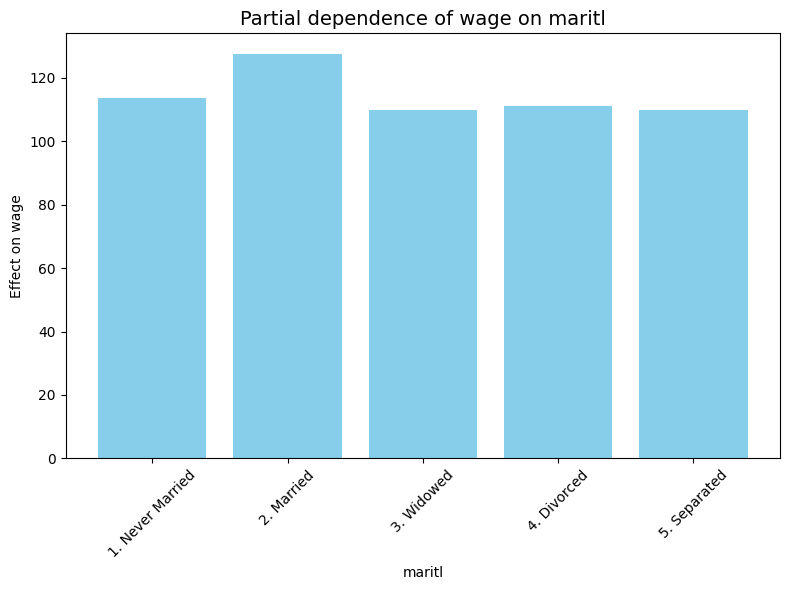

In [6]:
plot_effect("maritl")

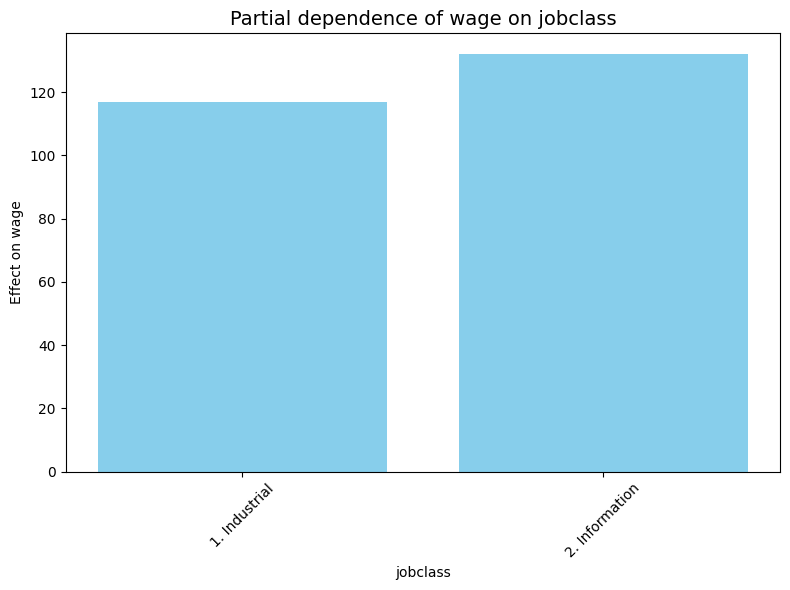

In [7]:
plot_effect("jobclass")

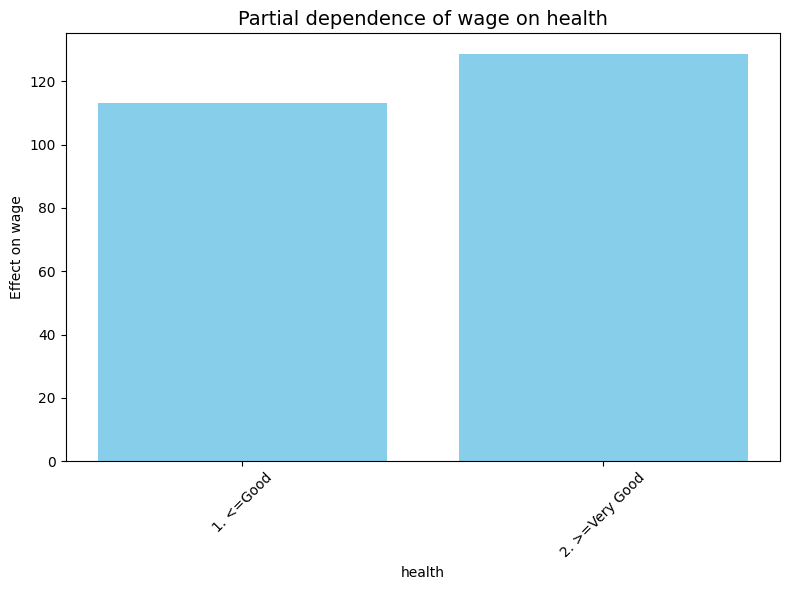

In [8]:
plot_effect("health")

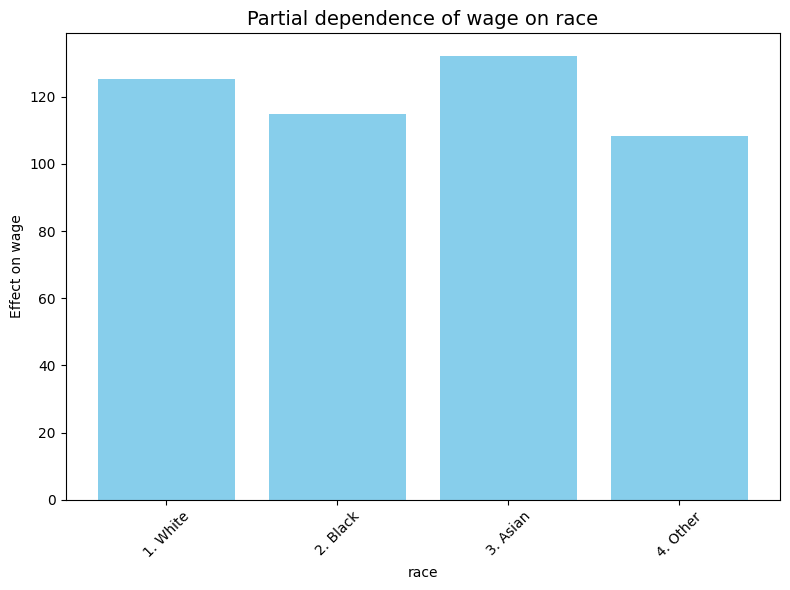

In [9]:
plot_effect("race")

The partial dependence plots reinforce the patterns observed in the earlier boxplots. Married individuals consistently show higher predicted wages, likely reflecting family responsibilities that incentivize career advancement. Among racial groups, Asians have the highest predicted earnings on average, followed by Whites and then Blacks, highlighting underlying structural and occupational differences. The information sector also predicts higher wages than industrial jobs, consistent with the greater skill and education requirements in that industry. By holding age and year constant, these plots isolate the effects of each categorical variable, providing a clear view of how marital status, race, and industry relate to wage outcomes.

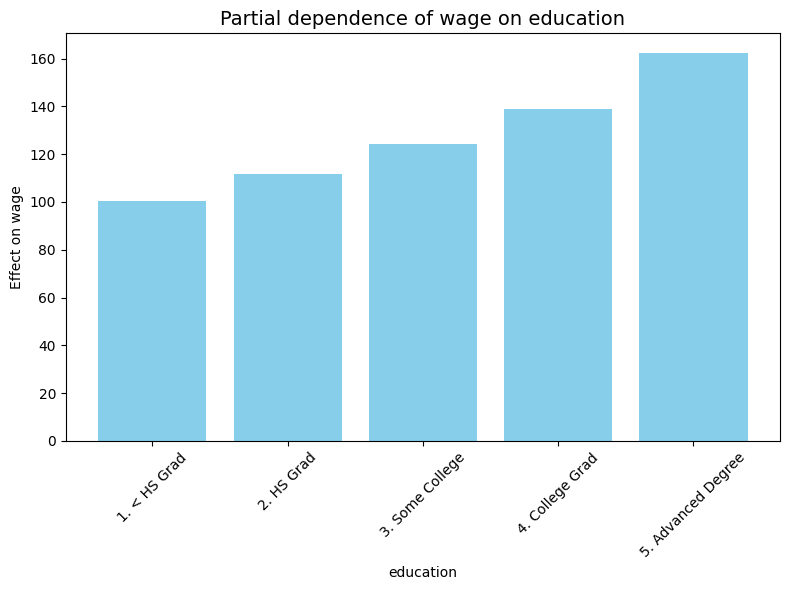

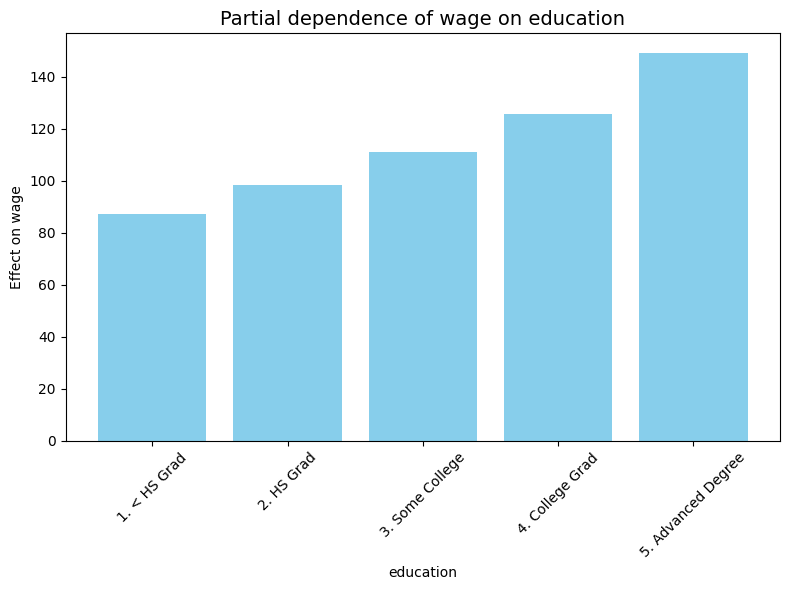

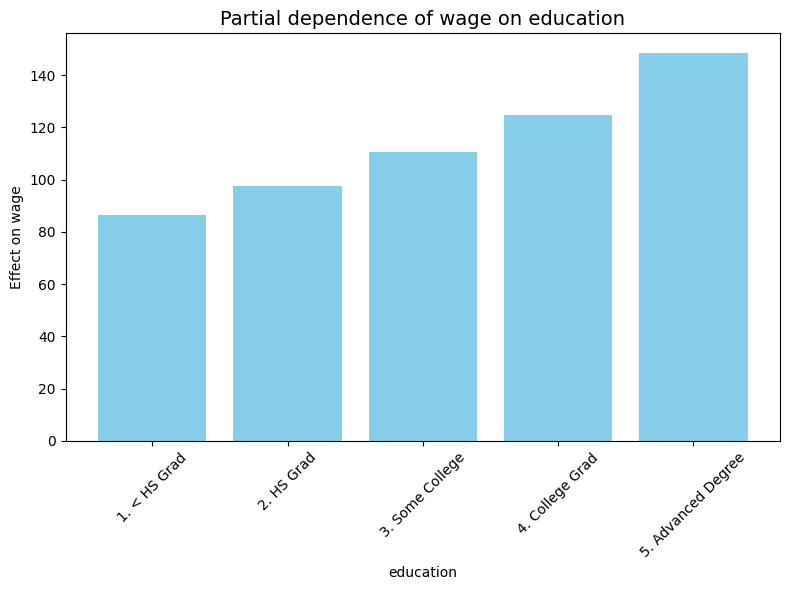

In [10]:
plot_effect("education", fixed_vars={"maritl": "2. Married"})
plot_effect("education", fixed_vars={"maritl": "4. Divorced"})
plot_effect("education", fixed_vars={"maritl": "1. Never Married"})


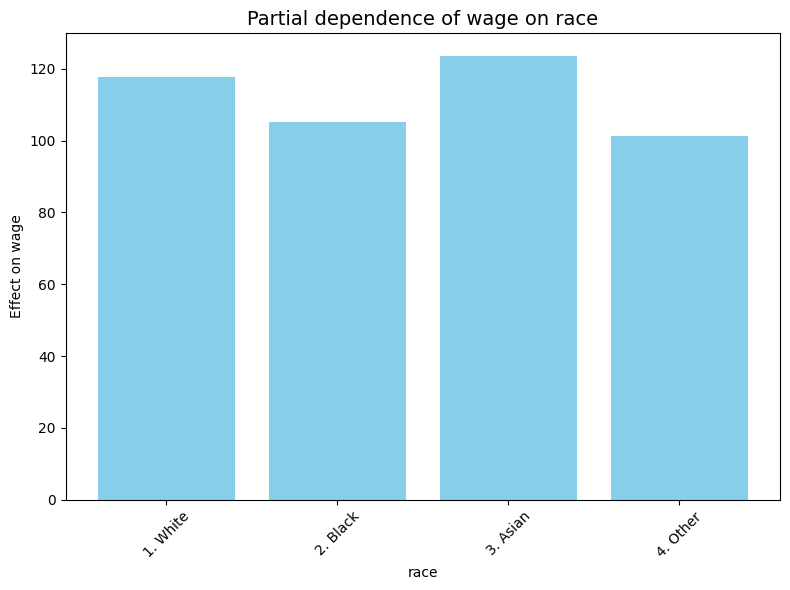

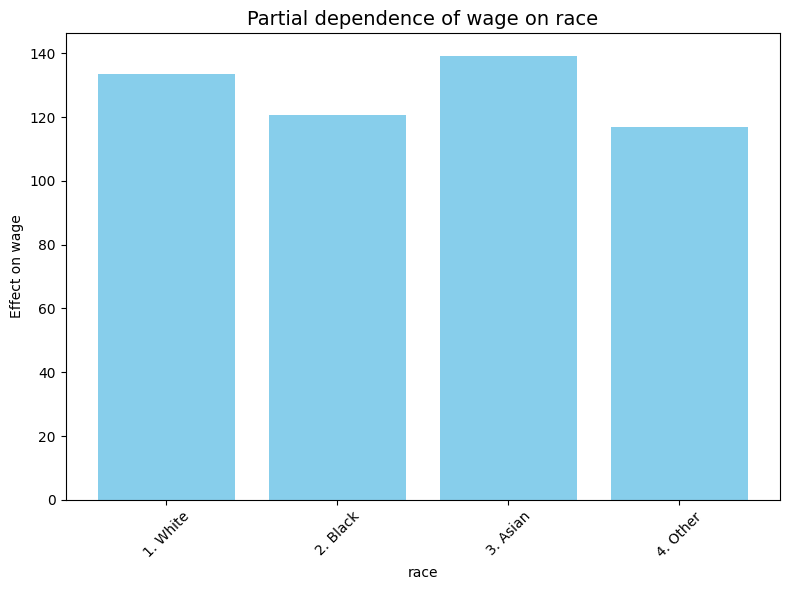

In [12]:
plot_effect("race", fixed_vars={"jobclass": "1. Industrial"})
plot_effect("race", fixed_vars={"jobclass": "2. Information"})


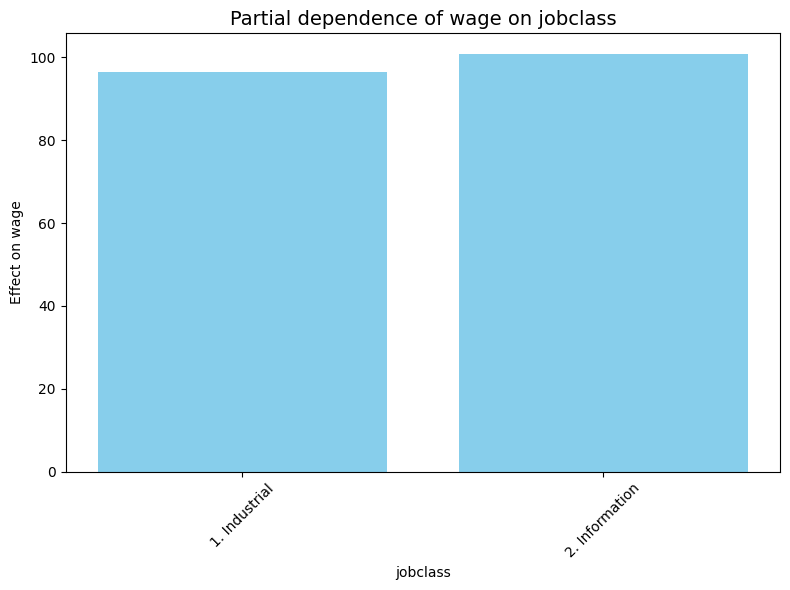

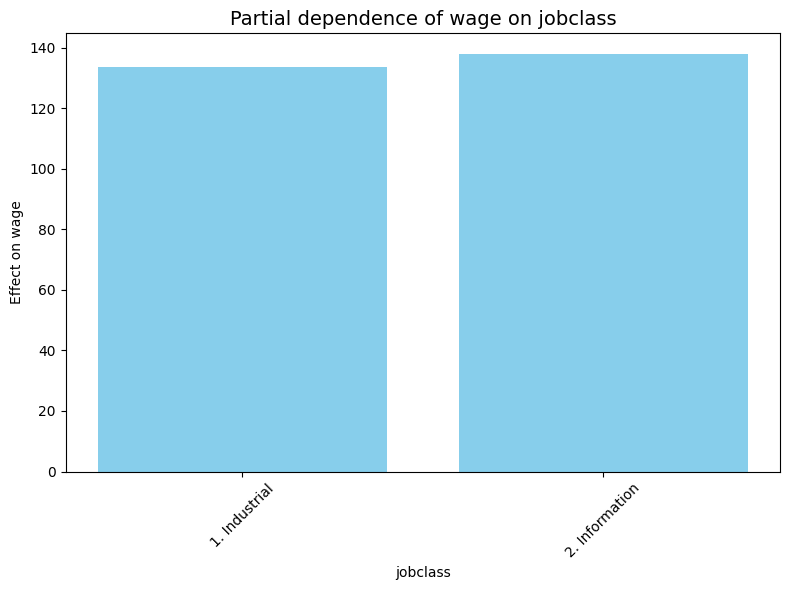

In [13]:
plot_effect("jobclass", fixed_vars={"education": "1. < HS Grad"})
plot_effect("jobclass", fixed_vars={"education": "4. College Grad"})


The similarity in all the plot_effect_fixed graphs suggests that the main variables, such as education, race, or job class, have a consistent effect on wages regardless of the values of other categorical factors like marital status or industry. In other words, these fixed variables contribute relatively little additional variation, and the primary drivers of wage differences appear to be the main predictors themselves. This implies that, within this dataset, the effect of a variable like education on wage is largely uniform across subgroups, and any interactions between these categorical variables are either weak or not captured by the current additive GAM model. To explore potential interactions more effectively, explicit interaction terms or alternative modeling approaches would be needed.